In [ ]:
import numpy as np
import random
from matplotlib import pyplot as plt
random.seed(42)

In [ ]:
dataset_path = "/content/drive/MyDrive/animals"
animal_types = ['cats', 'dogs', 'panda']

# Setting image size 32x32, total 100 images, and k values ranging 2 to 10

In [ ]:
image_size = 32
total_images = 100
k_values = list(range(2, 10))

# Choosing 1000 images from each class

In [ ]:
image_paths = []
labels = []
for animal in animal_types:
    for i in range(1, 1001):
        filename = f"{animal}_{str(i).zfill(5)}.jpg"
        path = f"{dataset_path}/{animal}/{filename}"
        image_paths.append(path)
        labels.append(animal)

# Randomly selecting 100 images

In [ ]:
indices = random.sample(range(len(image_paths)), 100)
selected_paths = [image_paths[i] for i in indices]
selected_labels = [labels[i] for i in indices]

In [ ]:
def rgb_to_grayscale(image_array):
    if image_array.ndim == 3 and image_array.shape[-1] == 3:
        return np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])
    return image_array

# Converting the colord images to black and white images.
Resizing the image to 32 x 32
Converting images from matrix to vector.
Mapping the labels and images to int
Label encoding

In [ ]:
images = []
final_labels = []
for path, label in zip(selected_paths, selected_labels):
    try:
        img = plt.imread(path)
        if img.dtype == np.float32 or img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        gray = rgb_to_grayscale(img)
        resized = gray[:image_size, :image_size]
        flattened = resized.flatten()
        images.append(flattened)
        final_labels.append(label)
    except Exception as e:
        continue

X = np.array(images)
Y = np.array(final_labels)\

label_to_int = {label: i for i, label in enumerate(sorted(set(Y)))}
int_to_label = {v: k for k, v in label_to_int.items()}
encoded = np.array([label_to_int[label] for label in Y])

# Defining L1 and L2 distance functions

In [ ]:
def l1_distance(a, b):
    return np.sum(np.abs(a - b))

def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [ ]:
def predict(X_train, y_train, x_test, k, dist_func):
    distances = [dist_func(x_test, x) for x in X_train]
    nearest = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest]
    values, counts = np.unique(nearest_labels, return_counts=True)
    return values[np.argmax(counts)]

In [ ]:
def cross_validation(X, Y, k_values, folds=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_size = len(X) // folds
    fold_indices = [indices[i*fold_size:(i+1)*fold_size] for i in range(folds)]

    accuracy_l1 = {k: [] for k in k_values}
    accuracy_l2 = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = fold_indices[i]
        train_idx = np.hstack([fold_indices[j] for j in range(folds) if j != i])
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]

        for k in k_values:
            correct_l1 = correct_l2 = 0
            for x, y_true in zip(X_val, Y_val):
                pred_l1 = predict(X_train, Y_train, x, k, l1_distance)
                pred_l2 = predict(X_train, Y_train, x, k, l2_distance)
                correct_l1 += int(pred_l1 == y_true)
                correct_l2 += int(pred_l2 == y_true)
            accuracy_l1[k].append(correct_l1 / len(Y_val))
            accuracy_l2[k].append(correct_l2 / len(Y_val))
        print(f"Fold {i+1} completed.")

    avg_l1 = {k: np.mean(accuracy_l1[k]) for k in k_values}
    avg_l2 = {k: np.mean(accuracy_l2[k]) for k in k_values}
    return avg_l1, avg_l2

In [ ]:
avg_l1, avg_l2 = cross_validation(X, encoded, k_values)

Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Fold 5 completed.


Comparison between L1 and L2 distance

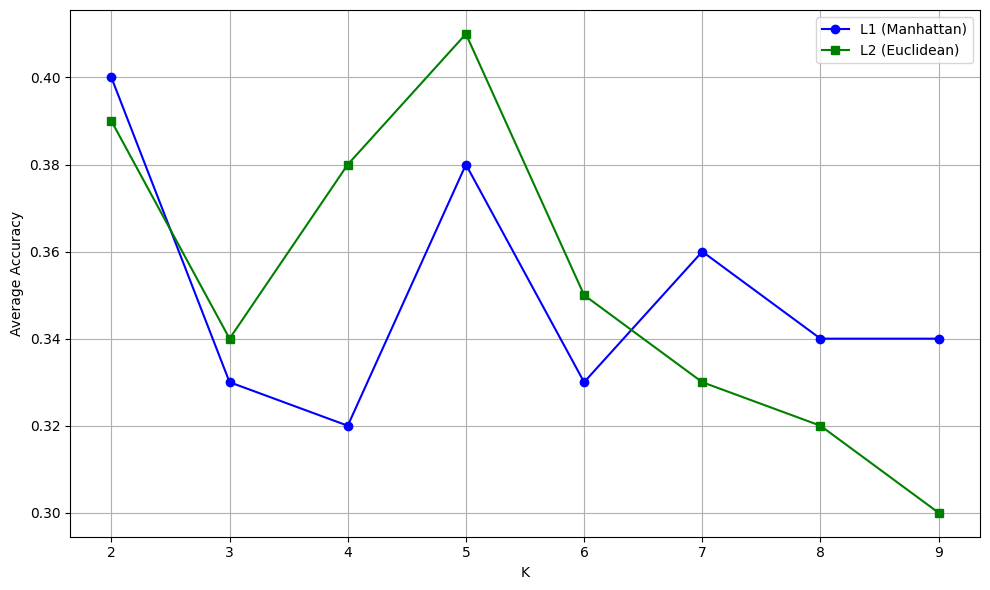

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, [avg_l1[k] for k in k_values], marker='o', label='L1 (Manhattan)', color='blue')
plt.plot(k_values, [avg_l2[k] for k in k_values], marker='s', label='L2 (Euclidean)', color='green')
plt.xlabel("K")
plt.ylabel("Average Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# From this graph it can be noticed that L2 is producing better average accuracy at particular values of k, maximizing at k = 5 k = 5 with an accuracy just above 0.40, while L1 peaks at k = 2 k=2 with lower accuracy. While both metrics change with increasing k, L2 generally performs better for mid-range k values. This is likely due to its sensitivity to overall feature magnitudes, which may capture more global patterns in grayscale images. However, the total accuracy level is somewhat poor, due to proper image scaling, and also no dedicated libraries for knn implementaion has been used.

In [ ]:
best_k_l1 = max(avg_l1, key=avg_l1.get)
best_k_l2 = max(avg_l2, key=avg_l2.get)

Showing the top 5 predictions

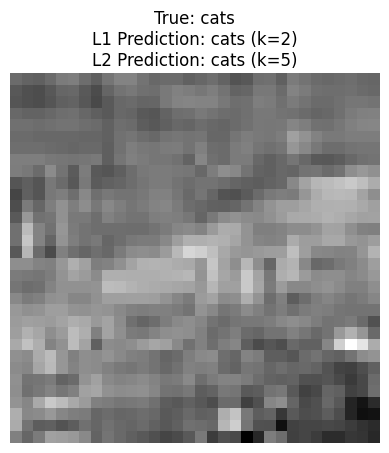

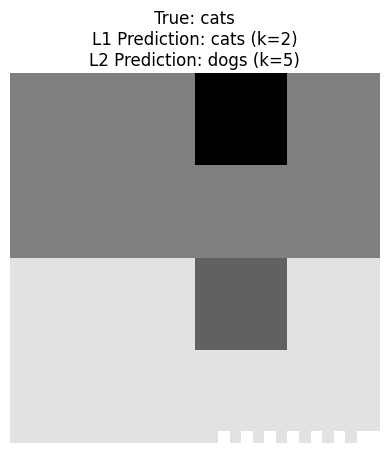

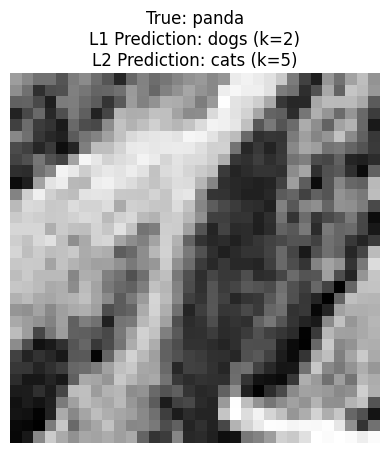

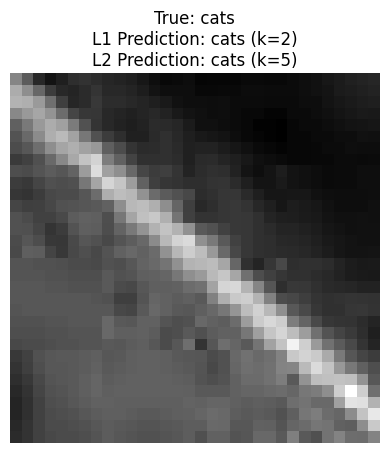

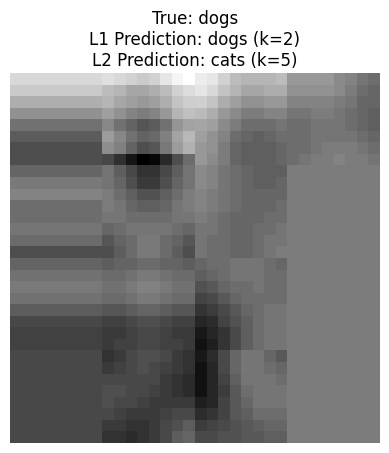

In [ ]:
test_indices = random.sample(range(len(X)), 5)
X_test = X[test_indices]
Y_test = encoded[test_indices]

for i, (x, true_label) in enumerate(zip(X_test, Y_test)):
    pred_l1 = predict(X, encoded, x, k=best_k_l1, dist_func=l1_distance)
    pred_l2 = predict(X, encoded, x, k=best_k_l2, dist_func=l2_distance)

    fig, ax = plt.subplots()
    ax.imshow(x.reshape(32, 32), cmap='gray')
    ax.axis('off')
    ax.set_title(
        f"True: {int_to_label[true_label]}\n"
        f"L1 Prediction: {int_to_label[pred_l1]} (k={best_k_l1})\n"
        f"L2 Prediction: {int_to_label[pred_l2]} (k={best_k_l2})"
    )
    plt.show()